In [1]:
import sys
sys.path.append('..')
from economic_brazil.coleta_dados.coleta_economic_brazil import dados_bcb
from economic_brazil.visualizacoes_graficas.codigos_graficos import Graficos
from economic_brazil.coleta_dados.economic_data_brazil import data_economic
from economic_brazil.processando_dados.data_processing import criando_dummy_covid, criando_defasagens,criando_mes_ano_dia,escalando_dados
from economic_brazil.processando_dados.estacionaridade import Estacionaridade
from economic_brazil.processando_dados.divisao_treino_teste import treino_test_dados,treino_teste_seies_temporal
from economic_brazil.treinamento.arima_treinamento import Arima
from economic_brazil.treinamento.modelos_treinamento import TreinamentoModelos
from economic_brazil.treinamento.treinamento_modelos_tuning import TimeSeriesModelTuner
from economic_brazil.analisando_modelos.regressao_conformal import ConformalRegressionPlotter, ConformalAvaliandoMetodo
from economic_brazil.analisando_modelos.analise_modelos_regressao import MetricasModelos
from economic_brazil.treinamento.redes_neurais_recorrentes import RnnModel
from economic_brazil.analisando_modelos.importancia_carecteristicas import ImportanciaRandomForest,TratandoDados,ImportanciaShap


2024-05-14 12:25:26.574898: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 12:25:26.740487: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 12:25:32.213639: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 12:25:52.893603: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 12:26:39.550451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:
dados = data_economic()

In [3]:
random = ImportanciaRandomForest(dados)

O tamanho do treino e  (243, 17)
O tamanho do teste e  (50, 17)


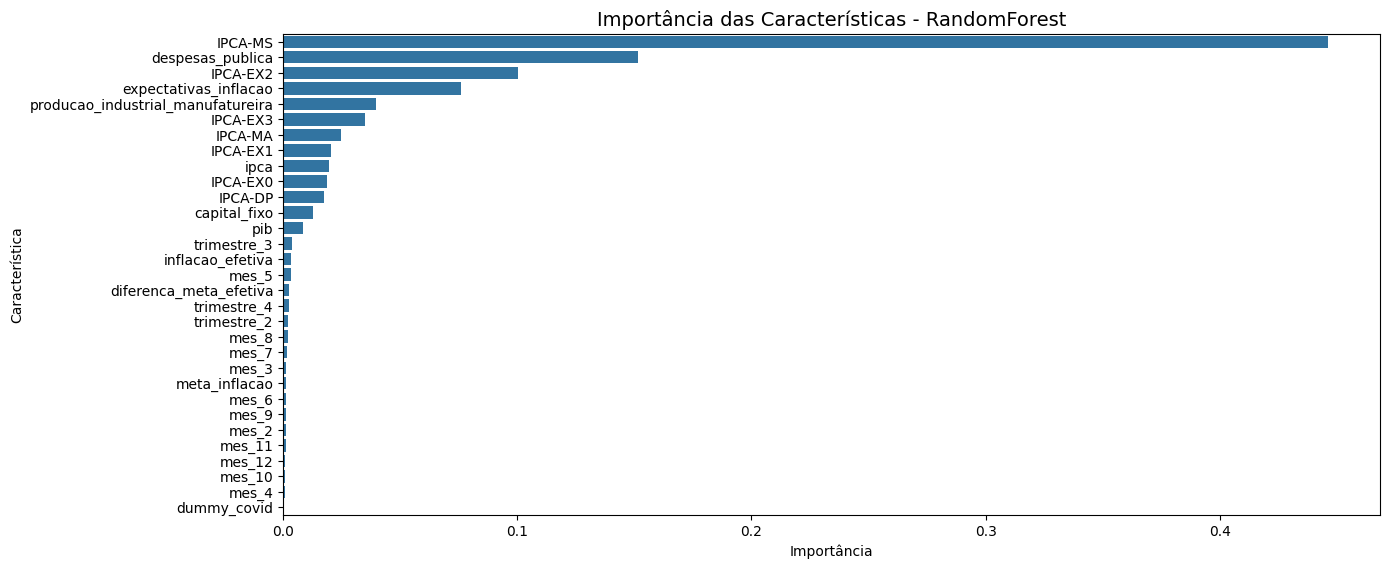

In [4]:
random.importancia_caracteristicas()

O tamanho do treino e  (243, 17)
O tamanho do teste e  (50, 17)


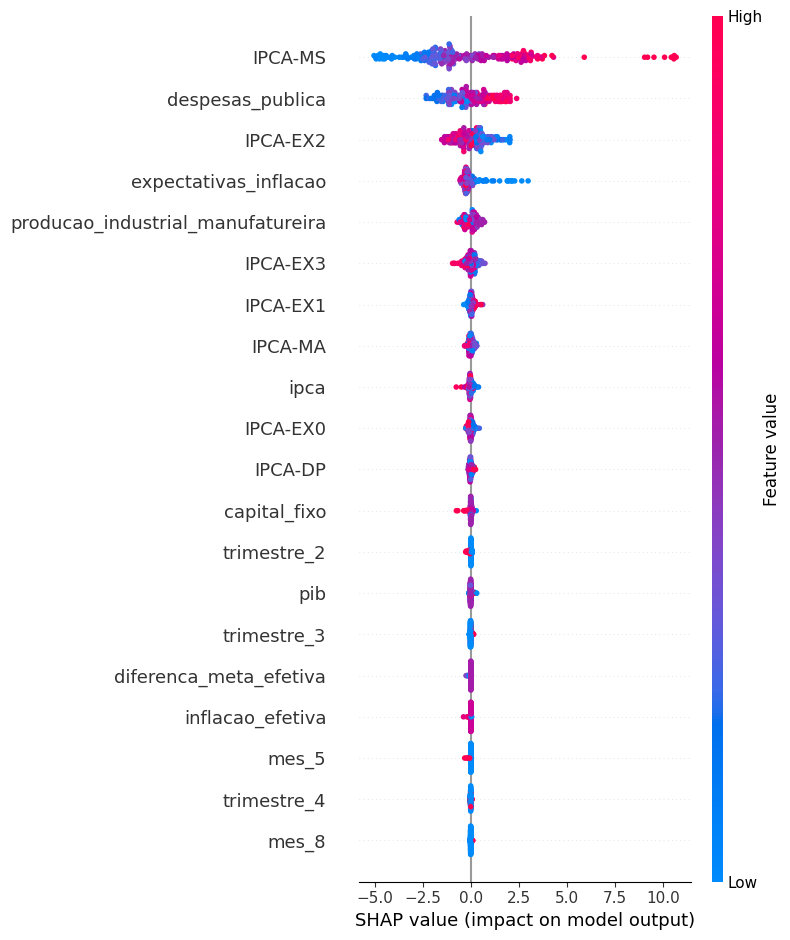

In [5]:
impor_shap = ImportanciaShap(dados)
impor_shap.summary_plot_shap()

In [3]:
impor_shap.force_plot_shap()


KeyboardInterrupt



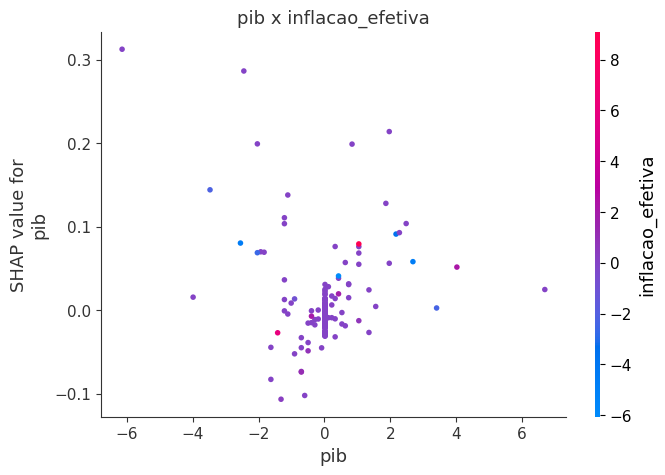

In [7]:
impor_shap.shap_dependence_plot('pib','inflacao_efetiva')

# Tratamento

In [4]:
treino, teste = treino_test_dados(dados,data_divisao='2020-04-01',treino_teste=True)

O tamanho do treino e  (243, 17)
O tamanho do teste e  (50, 17)


In [5]:
# importar PCA
from sklearn.decomposition import PCA

In [5]:
estacionaridade = Estacionaridade()
from sklearn.decomposition import PCA
train_covid = criando_dummy_covid(treino,inicio_periodo='2020-04-01', fim_periodo='2020-05-01')
train_est = estacionaridade.corrigindo_nao_estacionaridade(train_covid,'selic')
train_data = criando_mes_ano_dia(train_est,mes=True,trimestre=True,dummy=True,coluns=['mes','trimestre'])
train_defas = criando_defasagens(train_data,numero_defasagens=4)[4:]
y_train = train_defas['selic'].values
x_train = train_defas.loc[:, train_defas.columns != 'selic'].values
x_train_scaler,scaler = escalando_dados(x_train,tipo='scaler')
pca = PCA(n_components=6)
x_train_pca = pca.fit_transform(x_train_scaler)
##teste
test_covid = criando_dummy_covid(teste,inicio_periodo='2020-04-01', fim_periodo='2020-05-01')
test_est = estacionaridade.corrigindo_nao_estacionaridade(test_covid,'selic')
test_data = criando_mes_ano_dia(test_est,mes=True,trimestre=True,dummy=True,coluns=['mes','trimestre'])
test_defas = criando_defasagens(test_data,numero_defasagens=4)[4:]
index = test_defas.index
y_test= test_defas['selic'].values
x_test = test_defas.loc[:, train_defas.columns != 'selic'].values
x_test_scaler = scaler.transform(x_test)
x_teste_pca = pca.transform(x_test_scaler)


In [6]:
recorrentes = RnnModel()

In [7]:
x_train_lstm , y_train_lstm =recorrentes.create_dataset(x_train_pca,y_train, time_step=10)
x_test_lstm , y_test_lstm =recorrentes.create_dataset(x_teste_pca,y_test, time_step=10)

In [8]:
model_lstm = recorrentes.create_rnn_model(input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]), num_layers=3, units=50, dropout_rate=0.2, num_outputs=1, optimizer='adam', loss='mean_squared_error',activation='relu')

In [9]:
training = recorrentes.treinar_modelo(model_lstm, x_train_lstm, y_train_lstm, epochs=100, batch_size=32,test_data=True, X_test=x_test_lstm, y_test=y_test_lstm)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.0000e+00 - loss: 187.8828 - val_accuracy: 0.0000e+00 - val_loss: 131.9492
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0000e+00 - loss: 169.9764 - val_accuracy: 0.0000e+00 - val_loss: 116.9219
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 131.8861 - val_accuracy: 0.0000e+00 - val_loss: 81.5310
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 79.0916 - val_accuracy: 0.0000e+00 - val_loss: 15.9310
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 32.6397 - val_accuracy: 0.0000e+00 - val_loss: 7.8372
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 24.0153 - val_accuracy: 0.0000e+00 - val_loss: 12.7179
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 23.9154 - val_accuracy: 0.0000e+00 - val_loss: 9.8791
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

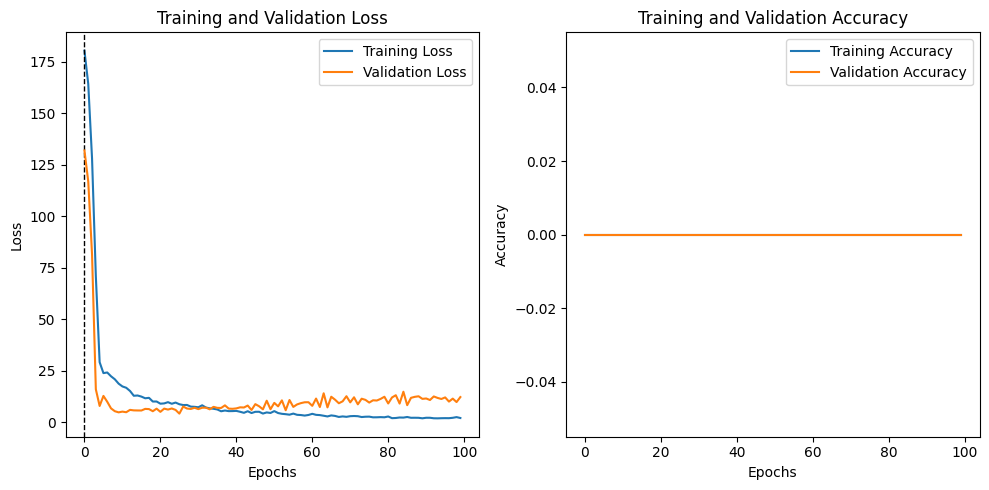

In [10]:
recorrentes.plotar_grafico(training)

In [12]:
import keras_tuner
import keras
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  model.add(keras.layers.Dense(1, activation='relu'))
  model.compile(loss='mse')
  return model

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

tuner.search(x_train_lstm, y_train_lstm, epochs=5, validation_data=(x_test_lstm, y_test_lstm))
best_model = tuner.get_best_models()[0]

Trial 3 Complete [00h 00m 01s]
val_loss: 65.8755111694336

Best val_loss So Far: 65.8755111694336
Total elapsed time: 00h 00m 05s


In [26]:
import numpy as np
import keras_tuner
import tensorflow as tf
from tensorflow import keras

# Example function to build the LSTM model
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=hp.Int('units', min_value=8, max_value=64, step=8),
        activation='relu',
        input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]),
        return_sequences=True))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(keras.layers.LSTM(
        units=hp.Int('units', min_value=8, max_value=64, step=8),
        activation='relu'))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse')
    return model

# Configure the Keras Tuner
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    overwrite=True)

# Start the search for the best model
tuner.search(x_train_lstm, y_train_lstm, epochs=10, validation_data=(x_test_lstm, y_test_lstm))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Optionally, print a summary of the best model
best_model.summary()


Trial 5 Complete [00h 00m 21s]
val_loss: 127.71595764160156

Best val_loss So Far: 6.0558516184488935
Total elapsed time: 00h 01m 48s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 40)         │         7,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,521 (80.16 KB)

 Trainable params: 20,521 (80.16 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
best_model.fit(x_train_lstm, y_train_lstm, epochs=10, validation_data=(x_test_lstm, y_test_lstm))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 16.9983 - val_loss: 12.3862
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.4475 - val_loss: 9.8532
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.1230 - val_loss: 10.0996
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.8737 - val_loss: 9.6182
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.3592 - val_loss: 4.0587
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.9750 - val_loss: 12.7367
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.5253 - val_loss: 5.3631
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.8699 - val_loss: 9.8165
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.2008 - val_loss: 5.1337
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.0204 - val_loss: 11.5195


In [28]:
best_model.predict(x_test_lstm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


array([[ 5.6737766],
       [ 6.1766014],
       [ 7.535707 ],
       [ 8.077753 ],
       [ 7.9799685],
       [ 7.4903116],
       [ 7.459818 ],
       [ 7.7826896],
       [ 8.262577 ],
       [ 8.461463 ],
       [ 9.103826 ],
       [ 9.506905 ],
       [ 9.940664 ],
       [ 9.958191 ],
       [10.782728 ],
       [10.852482 ],
       [11.505643 ],
       [11.309527 ],
       [11.256603 ],
       [10.674626 ],
       [11.116623 ],
       [11.06948  ],
       [12.158547 ],
       [10.507538 ],
       [10.470763 ],
       [ 9.153839 ],
       [ 8.146642 ],
       [ 7.100081 ],
       [ 6.346581 ],
       [ 6.310761 ],
       [ 6.024857 ],
       [ 5.896007 ],
       [ 6.49102  ],
       [ 6.725099 ],
       [ 7.5993543]], dtype=float32)